In [16]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

In [1]:
from typing import List
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_teddynote.models import get_model_name, LLMs

# 사용자 요구사항 수집을 위한 시스템 메시지 템플릿
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool.

[IMPORTANT] Your conversation should be in Korean. Your generated prompt should be in English."""


# 사용자 메시지 목록을 받아 시스템 메시지와 결합하여 반환
def get_messages_info(messages):
    # 사용자 요구사항 수집을 위한 시스템 메시지와 기존 메시지 결합
    return [SystemMessage(content=template)] + messages


# LLM에 대한 프롬프트 지침을 정의하는 데이터 모델
class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    # 프롬프트의 목표
    objective: str
    # 프롬프트 템플릿에 전달될 변수 목록
    variables: List[str]
    # 출력에서 피해야 할 제약 조건 목록
    constraints: List[str]
    # 출력이 반드시 따라야 할 요구 사항 목록
    requirements: List[str]


# 최신 LLM 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)
# LLM 초기화
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)
# PromptInstructions 구조체를 바인딩
llm_with_tool = llm.bind_tools([PromptInstructions])


# 상태 정보를 기반으로 메시지 체인을 생성하고 LLM 호출
def info_chain(state):
    # 상태에서 메시지 정보를 가져와 시스템 메시지와 결합
    messages = get_messages_info(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm_with_tool.invoke(messages)
    # 생성된 응답을 메시지 목록으로 반환
    return {"messages": [response]}

In [2]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# 프롬프트를 생성하는 메타 프롬프트 정의(OpenAI 메타 프롬프트 엔지니어링 가이드 참고)
META_PROMPT = """Given a task description or existing prompt, produce a detailed system prompt to guide a language model in completing the task effectively.

# Guidelines

- Understand the Task: Grasp the main objective, goals, requirements, constraints, and expected output.
- Minimal Changes: If an existing prompt is provided, improve it only if it's simple. For complex prompts, enhance clarity and add missing elements without altering the original structure.
- Reasoning Before Conclusions**: Encourage reasoning steps before any conclusions are reached. ATTENTION! If the user provides examples where the reasoning happens afterward, REVERSE the order! NEVER START EXAMPLES WITH CONCLUSIONS!
    - Reasoning Order: Call out reasoning portions of the prompt and conclusion parts (specific fields by name). For each, determine the ORDER in which this is done, and whether it needs to be reversed.
    - Conclusion, classifications, or results should ALWAYS appear last.
- Examples: Include high-quality examples if helpful, using placeholders [in brackets] for complex elements.
   - What kinds of examples may need to be included, how many, and whether they are complex enough to benefit from placeholders.
- Clarity and Conciseness: Use clear, specific language. Avoid unnecessary instructions or bland statements.
- Formatting: Use markdown features for readability. DO NOT USE ``` CODE BLOCKS UNLESS SPECIFICALLY REQUESTED.
- Preserve User Content: If the input task or prompt includes extensive guidelines or examples, preserve them entirely, or as closely as possible. If they are vague, consider breaking down into sub-steps. Keep any details, guidelines, examples, variables, or placeholders provided by the user.
- Constants: DO include constants in the prompt, as they are not susceptible to prompt injection. Such as guides, rubrics, and examples.
- Output Format: Explicitly the most appropriate output format, in detail. This should include length and syntax (e.g. short sentence, paragraph, JSON, etc.)
    - For tasks outputting well-defined or structured data (classification, JSON, etc.) bias toward outputting a JSON.
    - JSON should never be wrapped in code blocks (```) unless explicitly requested.

The final prompt you output should adhere to the following structure below. Do not include any additional commentary, only output the completed system prompt. SPECIFICALLY, do not include any additional messages at the start or end of the prompt. (e.g. no "---")

[Concise instruction describing the task - this should be the first line in the prompt, no section header]

[Additional details as needed.]

[Optional sections with headings or bullet points for detailed steps.]

# Steps [optional]

[optional: a detailed breakdown of the steps necessary to accomplish the task]

# Output Format

[Specifically call out how the output should be formatted, be it response length, structure e.g. JSON, markdown, etc]

[User given variables should be wrapped in {{brackets}}]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# Examples [optional]

[Optional: 1-3 well-defined examples with placeholders if necessary. Clearly mark where examples start and end, and what the input and output are. User placeholders as necessary.]
[If the examples are shorter than what a realistic example is expected to be, make a reference with () explaining how real examples should be longer / shorter / different. AND USE PLACEHOLDERS! ]

# Notes [optional]

[optional: edge cases, details, and an area to call or repeat out specific important considerations]

# Based on the following requirements, write a good prompt template:

{reqs}
"""


# 프롬프트 생성을 위한 메시지 가져오기 함수
# 도구 호출 이후의 메시지만 가져옴
def get_prompt_messages(messages: list):
    # 도구 호출 정보를 저장할 변수 초기화
    tool_call = None
    # 도구 호출 이후의 메시지를 저장할 리스트 초기화
    other_msgs = []
    # 메시지 목록을 순회하며 도구 호출 및 기타 메시지 처리
    for m in messages:
        # AI 메시지 중 도구 호출이 있는 경우 도구 호출 정보 저장
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        # ToolMessage는 건너뜀
        elif isinstance(m, ToolMessage):
            continue
        # 도구 호출 이후의 메시지를 리스트에 추가
        elif tool_call is not None:
            other_msgs.append(m)
    # 시스템 메시지와 도구 호출 이후의 메시지를 결합하여 반환
    return [SystemMessage(content=META_PROMPT.format(reqs=tool_call))] + other_msgs


# 프롬프트 생성 체인 함수 정의
def prompt_gen_chain(state):
    # 상태에서 프롬프트 메시지를 가져옴
    messages = get_prompt_messages(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm.invoke(messages)
    # 생성된 응답을 메시지 목록으로 반환
    return {"messages": [response]}

In [3]:
from langgraph.graph import END


# 상태 결정 함수 정의
# 상태에서 메시지 목록을 가져옴
def get_state(state):
    messages = state["messages"]
    # 마지막 메시지가 AIMessage이고 도구 호출이 있는 경우
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        # 도구 메시지를 추가해야 하는 상태 반환
        return "add_tool_message"
    # 마지막 메시지가 HumanMessage가 아닌 경우
    elif not isinstance(messages[-1], HumanMessage):
        # 대화 종료 상태 반환
        return END
    # 기본적으로 정보 수집 상태 반환
    return "info"

In [4]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 메모리에 대화 기록을 저장하기 위한 MemorySaver 초기화
memory = MemorySaver()

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


# 도구 메시지 추가 상태 노드 정의
@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0][
                    "id"
                ],  # 상태에서 도구 호출 ID를 가져와 메시지에 추가
            )
        ]
    }


# 조건부 상태 전환 정의
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])

# 엣지 정의
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)

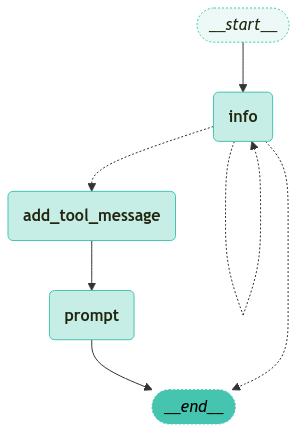

In [5]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [6]:
import uuid
from langchain_teddynote.messages import stream_graph

# 구성 설정 초기화 (고유한 thread_id 생성)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# 무한 루프 시작
while True:
    try:
        # 사용자 입력 받기
        user = input("User (q/Q to quit): ")
    except:
        pass

    # 사용자 입력 출력
    print(f"\n\033[93m[사용자] {user}\033[0m")

    # 'q' 또는 'Q' 입력 시 루프 종료
    if user in {"q", "Q"}:
        print("AI: 다음에 또 만나요!")
        break

    # 출력 변수 초기화
    output = None

    stream_graph(
        graph,
        {"messages": [HumanMessage(content=user)]},
        config=config,
        node_names=["info", "prompt"],
    )


[사용자] 치킨?

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
어떤 종류의 프롬프트 템플릿을 만들고 싶으신가요? 다음 정보를 알려주세요:

1. 프롬프트의 목표는 무엇인가요?
2. 프롬프트 템플릿에 전달될 변수는 무엇인가요?
3. 출력에서 하지 말아야 할 제약 조건은 무엇인가요?
4. 출력이 반드시 준수해야 할 요구 사항은 무엇인가요?
[사용자] 프롬프트의 목표는 sql쿼리를 짜는거야

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
좋습니다! SQL 쿼리를 작성하는 프롬프트를 만들기 위한 추가 정보를 알려주세요.

2. 프롬프트 템플릿에 전달될 변수는 무엇인가요?
3. 출력에서 하지 말아야 할 제약 조건은 무엇인가요?
4. 출력이 반드시 준수해야 할 요구 사항은 무엇인가요?
[사용자] 

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
변수, 제약 조건, 요구 사항에 대한 정보를 제공해 주시면 SQL 쿼리를 작성하는 프롬프트 템플릿을 만들 수 있습니다. 각 항목에 대해 구체적으로 말씀해 주시겠어요?
[사용자] ㅂ

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
죄송하지만, 정보를 제공해 주셔야 프롬프트 템플릿을 만들 수 있습니다. 다음 질문에 답해 주실 수 있나요?

1. 프롬프트의 목표는 SQL 쿼리를 작성하는 것이라고 하셨습니다. 
2. 프롬프트 템플릿에 전달될 변수는 무엇인가요?
3. 출력에서 하지 말아야 할 제약 조건은 무엇인가요?
4. 출력이 반드시 준수해야 할 요구 사항은 무엇인가요? 

이 정보를 알려주시면 감사하겠습니다!
[사용자] q
AI: 다음에 또 만나요!


In [8]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. MemorySaver 추가 ##########

# 메모리 저장소 초기화
memory = MemorySaver()

In [9]:
########## 6. interrupt_before 추가 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

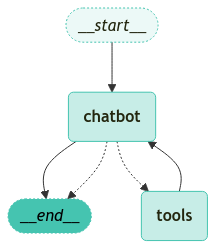

In [10]:
########## 7. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

In [11]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_Nn7yjpRkL3VSFAmGVw2Nl2gR)
 Call ID: call_Nn7yjpRkL3VSFAmGVw2Nl2gR
  Args:
    query: AI


In [12]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next

('tools',)

In [13]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(existing_message.tool_calls)

root[0]:
    [name]:
        name: search_keyword
    [args]:
        [query]:
            query: AI
    [id]:
        id: call_Nn7yjpRkL3VSFAmGVw2Nl2gR
    [type]:
        type: tool_call


In [14]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_Nn7yjpRkL3VSFAmGVw2Nl2gR)
 Call ID: call_Nn7yjpRkL3VSFAmGVw2Nl2gR
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxQalczWXdGRU45SzdQTXR1azNuZXd5ck4xaG9NT0dqR2JCWGVqeDdMaVpibGNwampZRkRPS0J3VWQ0WmxtOGxQZmRJOFRobzhOMWlLenRaRzdXM05COVcydXRxamctdmQtdzN6cENXMlhLaXZwRTloTnpXSmUwY0dJWU1B0gGWAUFVX3lxTE02T0hqWnp2ODdzMjZZMHlKaUtLTUlHVFFUQ0c2RXhPVWY1a2xhRWo0TmQ1RjZRX2FiY2o4NEhIM2ZGR1VPOTRSUzQ3cE9QcmVndDBET3h6M3N1SjJVWkZzLWt0YnFhR2tnV051ZFVRX1MzTktORXRYeTdFcTY0U3I2RXJzWGd2VGVGaEhsUzhiNHNaR2xaUQ?oc=5", "content": "AI 별들의 대전 ‘CES 2025’ 휩쓴 韓 ‘최고혁신상’ 제품은 - 조선비즈 - 조선비즈"}, {"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE9uV2JfRnJhRFl5d2JFeDZhOGN1ZUdYUHhSTUNYaDZUc09TdXdDdGZMM19GREZBMUdVR2QzZ1M0bXJEbkEwR1lQQkxLNnZPdXBCaDdJWTNB?oc=5", "content": 